## Sampling

In [28]:
import numpy as np
import pandas as pd
df_sample=pd.read_csv(r"C:\Users\23059\OneDrive\Desktop\Amiira\Y3S1\fyp\sample.csv")

In [29]:
df_sample.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [30]:
df_sample['type'] = df_sample['type'].replace({'CASH_OUT': 0, 'CASH_IN': 1, 'PAYMENT': 2, 'TRANSFER': 3, 'DEBIT': 4})

In [31]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label = le.fit_transform(df_sample['nameDest'])
label
df_sample.drop("nameDest", axis=1, inplace=True)
df_sample["nameDest"] = label

le = LabelEncoder()
label = le.fit_transform(df_sample['nameOrig'])
label
df_sample.drop("nameOrig", axis=1, inplace=True)
df_sample["nameOrig"] = label

df_sample['type'] = df_sample['type'].replace({'CASH_OUT': 0, 'CASH_IN': 1, 'PAYMENT': 2, 'TRANSFER': 3, 'DEBIT': 4})

In [32]:
X = df_sample.drop('isFraud', axis=1)
# Separate the target variable
y = df_sample['isFraud']

In [33]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# #Upsampling via SMOTE
# smote = SMOTE(sampling_strategy=0.4, random_state=0)

# #Downsample via RandomUnderSampler
# rus = RandomUnderSampler(sampling_strategy=0.9, random_state=0)

#Upsampling via SMOTE
smote = SMOTE(sampling_strategy=0.55, random_state=0)

#Application of the resampling methods
X_resampled, y_resampled = smote.fit_resample(X, y)
# X_resampled, y_resampled = rus.fit_resample(X_resampled, y_resampled)
# from imblearn.over_sampling import SMOTE

# #Upsampling via SMOTE
# smote = SMOTE(sampling_strategy=0.55, random_state=0)

# # Fit and apply the resampler to the entire dataset
# X_resampled, y_resampled = smote.fit_resample(X, y)

In [34]:
from imblearn.under_sampling import TomekLinks

#Resample using TomekLinks first
tomek_links = TomekLinks(sampling_strategy='majority')
X_train_resampled, y_train_resampled = tomek_links.fit_resample(X_resampled, y_resampled)

In [35]:
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours,OneSidedSelection
# resample the output of TomekLinks using EditedNearestNeighbours
enn = EditedNearestNeighbours(sampling_strategy='majority')
X_train_resampled_new, y_train_resampled_new = enn.fit_resample(X_train_resampled, y_train_resampled)

In [36]:
from imblearn.under_sampling import OneSidedSelection
# resample the output of EditedNearestNeighbours using One-Sided Selection
oss = OneSidedSelection(sampling_strategy='majority')
X_train_resampled_final, y_train_resampled_final = oss.fit_resample(X_train_resampled_new, y_train_resampled_new)

In [37]:
# reverse_map = {0: 'CASH_OUT', 1: 'CASH_IN', 2: 'PAYMENT', 3: 'TRANSFER', 4: 'DEBIT'}
# df_sample['type'] = df_sample['type'].replace(reverse_map)

In [38]:
combined_data = pd.concat([X_train_resampled_final, y_train_resampled_final], axis=1)

In [39]:
reverse_map = {0: 'CASH_OUT', 1: 'CASH_IN', 2: 'PAYMENT', 3: 'TRANSFER', 4: 'DEBIT'}
combined_data ['type'] = combined_data ['type'].replace(reverse_map)

In [40]:
from sklearn.cluster import KMeans

# This code transforms the continuous variables (step and amount) taking into account ‘isFraud Class’ which is the objective  
# of this research. A k-means cluster model with 3 features, ‘isFraud’, ‘step’ and ‘amount’ is used.
# The variables ‘step_cluster’ and ‘amount_cluster’ are created for every single transaction.

continuous_vars = ['step','amount','isFraud']

# Normalizing the data
normalized_df = (combined_data[continuous_vars] - combined_data[continuous_vars].mean()) / combined_data[continuous_vars].std()

# Determining the optimal number of clusters
kmeans_kwargs = {"init": "random", "n_init": 15, "max_iter": 400, "random_state": 14}
sse = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs,algorithm='full')
    kmeans.fit(normalized_df)
    sse.append(kmeans.inertia_)
    
# # Application of th elbow method 
# import matplotlib.pyplot as plt
# plt.style.use("fivethirtyeight")
# plt.plot(range(1, 11), sse)
# plt.xticks(range(1, 11))
# plt.xlabel("Number of Clusters")
# plt.ylabel("SSE")
# plt.show()

# Application of K-Means clustering
kmeans = KMeans(n_clusters=5, **kmeans_kwargs,algorithm='full',tol=0.0010)
kmeans.fit(normalized_df)
clusters = kmeans.predict(normalized_df)

# Using K-Means clustering to create clusters for the continuous variables "step", "amount" while taking "isFraud" into consideration
cluster_df = pd.DataFrame()
for var in continuous_vars:
    cluster_centers = kmeans.cluster_centers_[:, continuous_vars.index(var)]
    col_name = var + '_cluster'
    cluster_df[col_name] = kmeans.predict(normalized_df)
    
    # Replace cluster labels with desired values
    
    if var == 'isFraud':
        cluster_df[col_name] = cluster_df[col_name].apply(lambda x: 'Fraud' if x == 1 else 'No_Fraud')
  
    elif var=='amount':
        bin_edges = [0, 50000, 100000, 500000, 1000000, 5000000, 10000000, 60000000, 70000000]
        cluster_labels = ['0-50k', '50k-100k', '100k-500k', '500k-1M', '1M-5M', '5M-10M', '10M-60M', '60M-70M']
        cluster_df[col_name] = pd.cut(combined_data['amount'], bins=bin_edges, labels=cluster_labels)
   
    elif var == 'step':
        bin_edges = [1, 186, 372, 558, 743] 
        cluster_labels = ['1-186', '187-372', '373-558', '559-743']
        cluster_df[col_name] = pd.cut(combined_data['step'], bins=bin_edges, labels=cluster_labels)

# Create new dataframe to store the converted values
K_means_df = pd.DataFrame()
K_means_df = pd.concat([K_means_df, cluster_df], axis=1)

In [41]:
# from sklearn.metrics import silhouette_score

# silhouette_score = silhouette_score(normalized_df, clusters)
# print("Silhouette Score:", silhouette_score)

In [42]:
inertia = kmeans.inertia_
print("Inertia:", inertia)

Inertia: 525404.8577213791


In [43]:
from sklearn.metrics import davies_bouldin_score

davies_bouldin_score = davies_bouldin_score(normalized_df, clusters)
print("Davies-Bouldin Index:", davies_bouldin_score)

Davies-Bouldin Index: 0.6622280739934686


In [44]:
K_means_df

,step_cluster,amount_cluster,isFraud_cluster
0,1-186,50k-100k,No_Fraud
1,187-372,100k-500k,Fraud
2,1-186,100k-500k,No_Fraud
3,187-372,0-50k,Fraud
4,187-372,0-50k,Fraud
...,...,...,...
1076889,1-186,0-50k,No_Fraud
1076890,373-558,1M-5M,No_Fraud
1076891,373-558,0-50k,No_Fraud
1076892,187-372,1M-5M,No_Fraud


In [45]:
from tabulate import tabulate
from termcolor import colored

# Get the counts for each cluster label
amount_cluster_counts = cluster_df['amount_cluster'].value_counts()
step_cluster_counts = cluster_df['step_cluster'].value_counts()
isFraud_cluster_counts = cluster_df['isFraud_cluster'].value_counts()

# Print the counts with labels
print(colored("Amount cluster counts:", 'blue'))
print(tabulate(amount_cluster_counts.to_frame().T, headers='keys', tablefmt='fancy_grid', numalign='center', stralign='center', colalign=("center",), showindex=False, disable_numparse=True))

print(colored("\nStep cluster counts:", 'blue'))
print(tabulate(step_cluster_counts.to_frame().T, headers='keys', tablefmt='fancy_grid', numalign='center', stralign='center', colalign=("center",), showindex=False, disable_numparse=True))

print(colored("\nIsFraud cluster counts:", 'blue'))
print(tabulate(isFraud_cluster_counts.to_frame().T, headers='keys', tablefmt='fancy_grid', numalign='center', stralign='center', colalign=("center",), showindex=False, disable_numparse=True))

Amount cluster counts:
╒═════════════╤═════════╤════════════╤═════════╤═══════════╤══════════╤═══════════╤═══════════╕
│  100k-500k  │  0-50k  │  50k-100k  │  1M-5M  │  500k-1M  │  5M-10M  │  10M-60M  │  60M-70M  │
╞═════════════╪═════════╪════════════╪═════════╪═══════════╪══════════╪═══════════╪═══════════╡
│   389401    │ 355259  │   110709   │  95700  │   83300   │  42251   │    270    │     3     │
╘═════════════╧═════════╧════════════╧═════════╧═══════════╧══════════╧═══════════╧═══════════╛

Step cluster counts:
╒═══════════╤═════════╤═══════════╤═══════════╕
│  187-372  │  1-186  │  373-558  │  559-743  │
╞═══════════╪═════════╪═══════════╪═══════════╡
│  454289   │ 309545  │  221814   │   90961   │
╘═══════════╧═════════╧═══════════╧═══════════╛

IsFraud cluster counts:
╒════════════╤═════════╕
│  No_Fraud  │  Fraud  │
╞════════════╪═════════╡
│   733195   │ 343699  │
╘════════════╧═════════╛


In [46]:
# Check the data types of columns after conversion
print(K_means_df.dtypes)

step_cluster       category
amount_cluster     category
isFraud_cluster      object
dtype: object


In [47]:
K_means_df= pd.concat([combined_data['type'].reset_index(drop=True), K_means_df], axis=1)

In [48]:
K_means_df

,type,step_cluster,amount_cluster,isFraud_cluster
0,TRANSFER,1-186,50k-100k,No_Fraud
1,CASH_OUT,187-372,100k-500k,Fraud
2,CASH_IN,1-186,100k-500k,No_Fraud
3,PAYMENT,187-372,0-50k,Fraud
4,PAYMENT,187-372,0-50k,Fraud
...,...,...,...,...
1076889,PAYMENT,1-186,0-50k,No_Fraud
1076890,TRANSFER,373-558,1M-5M,No_Fraud
1076891,TRANSFER,373-558,0-50k,No_Fraud
1076892,TRANSFER,187-372,1M-5M,No_Fraud


In [49]:
# Check the data types of columns after conversion
print(K_means_df .dtypes)

type                 object
step_cluster       category
amount_cluster     category
isFraud_cluster      object
dtype: object


In [50]:
# Change data types to object
K_means_df = K_means_df .astype('object')

# Check the data types of columns after conversion
print(K_means_df .dtypes)

type               object
step_cluster       object
amount_cluster     object
isFraud_cluster    object
dtype: object


### Split

In [51]:
X = K_means_df.drop('isFraud_cluster', axis=1)
# Separate the target variable
y = K_means_df['isFraud_cluster']

from sklearn.model_selection import train_test_split

# Print class distribution before split
print(y.value_counts(normalize=True))

# Assuming X contains your features and y contains your target variable
X_train, X_test, y_train, y_test = train_test_split(X, y , test_size=0.1, stratify=y, random_state=2)

# Print class distribution after split
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

No_Fraud    0.680842
Fraud       0.319158
Name: isFraud_cluster, dtype: float64
No_Fraud    0.680842
Fraud       0.319158
Name: isFraud_cluster, dtype: float64
No_Fraud    0.680843
Fraud       0.319157
Name: isFraud_cluster, dtype: float64


In [52]:
analysis_data = pd.concat([X_train, y_train], axis=1)

In [53]:
# test_data = pd.concat([X_test, y_test], axis=1)
test_data = pd.concat([X_test, y_test], axis=1).reset_index(drop=True)
test_data

,type,step_cluster,amount_cluster,isFraud_cluster
0,CASH_OUT,187-372,50k-100k,No_Fraud
1,PAYMENT,1-186,0-50k,No_Fraud
2,TRANSFER,187-372,100k-500k,No_Fraud
3,TRANSFER,1-186,500k-1M,No_Fraud
4,TRANSFER,1-186,1M-5M,No_Fraud
...,...,...,...,...
107685,CASH_OUT,559-743,1M-5M,No_Fraud
107686,TRANSFER,559-743,0-50k,No_Fraud
107687,PAYMENT,187-372,0-50k,Fraud
107688,CASH_OUT,373-558,500k-1M,No_Fraud


In [54]:
# Change data types to object
K_means_df= K_means_df.astype('object')

# Check the data types of columns after conversion
print(K_means_df.dtypes)

type               object
step_cluster       object
amount_cluster     object
isFraud_cluster    object
dtype: object


[INFO]:  4 CPU cores will be allocated in parallel running
CHAID  tree is going to be built...


100%|██████████| 5/5 [00:02<00:00,  1.90it/s]


-------------------------
finished in  2.87679123878479  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  99.9357979776363 % on  93455  instances
Labels:  ['No_Fraud' 'Fraud']
Confusion matrix:  [[89581, 54], [6, 3814]]
Precision:  99.9398 %, Recall:  99.9933 %, F1:  99.9665 %
[INFO]:  4 CPU cores will be allocated in parallel running
CHAID  tree is going to be built...


100%|██████████| 5/5 [00:02<00:00,  1.72it/s]


-------------------------
finished in  3.080479860305786  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  99.93686801134236 % on  186910  instances
Labels:  ['No_Fraud' 'Fraud']
Confusion matrix:  [[179180, 108], [10, 7612]]
Precision:  99.9398 %, Recall:  99.9944 %, F1:  99.9671 %
[INFO]:  4 CPU cores will be allocated in parallel running
CHAID  tree is going to be built...


100%|██████████| 5/5 [00:04<00:00,  1.10it/s]


-------------------------
finished in  4.849314451217651  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  99.9393647566565 % on  280365  instances
Labels:  ['No_Fraud' 'Fraud']
Confusion matrix:  [[268877, 152], [18, 11318]]
Precision:  99.9435 %, Recall:  99.9933 %, F1:  99.9684 %
[INFO]:  4 CPU cores will be allocated in parallel running
CHAID  tree is going to be built...


100%|██████████| 5/5 [00:04<00:00,  1.06it/s]


-------------------------
finished in  5.066882610321045  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  99.94195067144615 % on  373820  instances
Labels:  ['No_Fraud' 'Fraud']
Confusion matrix:  [[358455, 193], [24, 15148]]
Precision:  99.9462 %, Recall:  99.9933 %, F1:  99.9697 %
[INFO]:  4 CPU cores will be allocated in parallel running
CHAID  tree is going to be built...


100%|██████████| 5/5 [00:05<00:00,  1.08s/it]


-------------------------
finished in  5.8621861934661865  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  99.94435836636164 % on  467276  instances
Labels:  ['No_Fraud' 'Fraud']
Confusion matrix:  [[447992, 232], [28, 19024]]
Precision:  99.9482 %, Recall:  99.9938 %, F1:  99.971 %
[INFO]:  4 CPU cores will be allocated in parallel running
CHAID  tree is going to be built...


100%|██████████| 5/5 [00:05<00:00,  1.03s/it]


-------------------------
finished in  5.514455080032349  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  99.94435834651553 % on  560731  instances
Labels:  ['No_Fraud' 'Fraud']
Confusion matrix:  [[537492, 271], [41, 22927]]
Precision:  99.9496 %, Recall:  99.9924 %, F1:  99.971 %
[INFO]:  4 CPU cores will be allocated in parallel running
CHAID  tree is going to be built...


100%|██████████| 5/5 [00:05<00:00,  1.02s/it]


-------------------------
finished in  5.659646034240723  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  99.94405260889106 % on  654186  instances
Labels:  ['No_Fraud' 'Fraud']
Confusion matrix:  [[627082, 314], [52, 26738]]
Precision:  99.95 %, Recall:  99.9917 %, F1:  99.9708 %
[INFO]:  4 CPU cores will be allocated in parallel running
CHAID  tree is going to be built...


100%|██████████| 5/5 [00:06<00:00,  1.23s/it]


-------------------------
finished in  6.707221984863281  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  99.94235201119254 % on  747641  instances
Labels:  ['No_Fraud' 'Fraud']
Confusion matrix:  [[716656, 369], [62, 30554]]
Precision:  99.9485 %, Recall:  99.9913 %, F1:  99.9699 %
[INFO]:  4 CPU cores will be allocated in parallel running
CHAID  tree is going to be built...


100%|██████████| 5/5 [00:05<00:00,  1.05s/it]


-------------------------
finished in  5.856890439987183  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  99.94305049601948 % on  841096  instances
Labels:  ['No_Fraud' 'Fraud']
Confusion matrix:  [[806208, 412], [67, 34409]]
Precision:  99.9489 %, Recall:  99.9917 %, F1:  99.9703 %
[INFO]:  4 CPU cores will be allocated in parallel running
CHAID  tree is going to be built...


100%|██████████| 5/5 [00:05<00:00,  1.11s/it]


-------------------------
finished in  6.3316969871521  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  99.94371634751197 % on  934552  instances
Labels:  ['No_Fraud' 'Fraud']
Confusion matrix:  [[895812, 454], [72, 38214]]
Precision:  99.9493 %, Recall:  99.992 %, F1:  99.9706 %


C:\Users\23059\anaconda3\envs\test2\lib\site-packages\sklearn\metrics\_classification.py:1580: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum))


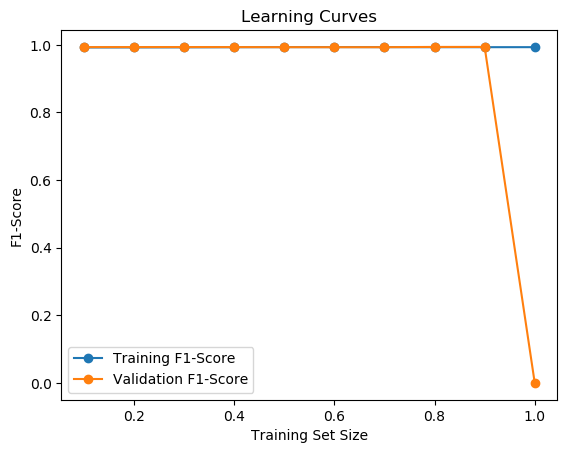

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from chefboost import Chefboost as chef

# Configure the model parameters
config = {
    'algorithm': 'CHAID',
    'learning_rate': 3.5,
    'enableParallelism': True,
    'max_depth': 4,
    'num_of_weak_classifier': 6,
    'enableRandomForest':True,
    'num_trees':6,
    'epochs':13,
    'enableMultitasking':True
}

# Store the sizes of the training set
train_sizes = np.linspace(0.1, 1.0, 10, endpoint=True)

# Initialize lists to store training and validation F1-scores
train_scores = []
val_scores = []

for train_size in train_sizes:
    # Calculate the number of samples for the current training set size
    num_samples = int(train_size * analysis_data.shape[0])

    # Split the data into training and validation sets
    train_data = analysis_data[:num_samples]
    val_data = analysis_data[num_samples:]

    # Train model
    model = chef.fit(train_data, config=config, target_label='isFraud_cluster')

    # Make predictions on the training set
    train_predictions = []
    for _, row in train_data.iterrows():
        prediction = chef.predict(model, row)
        train_predictions.append(prediction)

    # Make predictions on the validation set
    val_predictions = []
    for _, row in val_data.iterrows():
        prediction = chef.predict(model, row)
        val_predictions.append(prediction)

    # Calculate the F1-scores
    train_f1_score = f1_score(train_data['isFraud_cluster'], train_predictions, pos_label='Fraud', average='binary')
    val_f1_score = f1_score(val_data['isFraud_cluster'], val_predictions, pos_label='Fraud', average='binary')

    # Append the F1-scores to the lists
    train_scores.append(train_f1_score)
    val_scores.append(val_f1_score)

# Plot the learning curves
plt.plot(train_sizes, train_scores, 'o-', label='Training F1-Score')
plt.plot(train_sizes, val_scores, 'o-', label='Validation F1-Score')
plt.xlabel('Training Set Size')
plt.ylabel('F1-Score')
plt.title('Learning Curves')
plt.legend()
plt.show()

In [30]:
# Predict for all rows in the test data
predictions = []
TP = 0  # True Positives
FP = 0  # False Positives
TN = 0  # True Negatives
FN = 0  # False Negatives

for i in range(len(test_data)):
    test_instance = test_data.iloc[i]
    prediction = chef.predict(model, test_instance)
    predictions.append(prediction)

   # Compare the prediction with the actual target value
    if prediction == "Fraud" and y_test.iloc[i] == "Fraud":
        TP += 1
    elif prediction == "Fraud" and y_test.iloc[i] == "No_Fraud":
        FP += 1
    elif prediction == "No_Fraud" and y_test.iloc[i] == "No_Fraud":
        TN += 1
    elif prediction == "No_Fraud" and y_test.iloc[i] == "Fraud":
        FN += 1

# Print the predictions
print(predictions)

# Print the counts for TP, FP, TN, and FN
print("True Positives (TP):", TP)
print("False Positives (FP):", FP)
print("True Negatives (TN):", TN)
print("False Negatives (FN):", FN)

['No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud

In [31]:
# Calculate precision
precision = TP / (TP + FP)

# Calculate recall
recall = TP / (TP + FN)

# Calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

Precision: 0.998348667138476
Recall: 0.9851024208566108
F1 Score: 0.9916813122437024


[INFO]:  4 CPU cores will be allocated in parallel running
CHAID  tree is going to be built...


100%|██████████| 5/5 [00:11<00:00,  2.31s/it]


-------------------------
finished in  11.740708827972412  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  81.0926537350392 % on  96920  instances
Labels:  ['No_Fraud' 'Fraud']
Confusion matrix:  [[54100, 6231], [12094, 24495]]
Precision:  89.672 %, Recall:  81.7295 %, F1:  85.5167 %
[INFO]:  4 CPU cores will be allocated in parallel running
CHAID  tree is going to be built...


100%|██████████| 5/5 [00:13<00:00,  2.63s/it]


-------------------------
finished in  13.49677300453186  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  81.17158481221627 % on  193840  instances
Labels:  ['No_Fraud' 'Fraud']
Confusion matrix:  [[108147, 12401], [24096, 49196]]
Precision:  89.7128 %, Recall:  81.779 %, F1:  85.5624 %
[INFO]:  4 CPU cores will be allocated in parallel running
CHAID  tree is going to be built...


100%|██████████| 5/5 [00:13<00:00,  2.76s/it]


-------------------------
finished in  14.166732788085938  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  81.14740284976321 % on  290761  instances
Labels:  ['No_Fraud' 'Fraud']
Confusion matrix:  [[162120, 18551], [36265, 73825]]
Precision:  89.7322 %, Recall:  81.7199 %, F1:  85.5388 %
[INFO]:  4 CPU cores will be allocated in parallel running
CHAID  tree is going to be built...


100%|██████████| 5/5 [00:21<00:00,  4.20s/it]


-------------------------
finished in  21.537040948867798  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  81.18143525217899 % on  387681  instances
Labels:  ['No_Fraud' 'Fraud']
Confusion matrix:  [[216304, 24752], [48204, 98421]]
Precision:  89.7318 %, Recall:  81.776 %, F1:  85.5694 %
[INFO]:  4 CPU cores will be allocated in parallel running
CHAID  tree is going to be built...


100%|██████████| 5/5 [00:15<00:00,  3.02s/it]


-------------------------
finished in  15.544530868530273  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  81.13812984676085 % on  484602  instances
Labels:  ['No_Fraud' 'Fraud']
Confusion matrix:  [[270207, 31096], [60309, 122990]]
Precision:  89.6795 %, Recall:  81.7531 %, F1:  85.5331 %
[INFO]:  4 CPU cores will be allocated in parallel running
CHAID  tree is going to be built...


100%|██████████| 5/5 [00:13<00:00,  2.80s/it]


-------------------------
finished in  14.530686378479004  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  81.1606439653186 % on  581522  instances
Labels:  ['No_Fraud' 'Fraud']
Confusion matrix:  [[323964, 37309], [72246, 148003]]
Precision:  89.6729 %, Recall:  81.7657 %, F1:  85.5369 %
[INFO]:  4 CPU cores will be allocated in parallel running
CHAID  tree is going to be built...


100%|██████████| 5/5 [00:15<00:00,  3.16s/it]


-------------------------
finished in  16.381192922592163  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  81.17790466981702 % on  678442  instances
Labels:  ['No_Fraud' 'Fraud']
Confusion matrix:  [[378024, 43472], [84225, 172721]]
Precision:  89.6863 %, Recall:  81.7793 %, F1:  85.5505 %
[INFO]:  4 CPU cores will be allocated in parallel running
CHAID  tree is going to be built...


100%|██████████| 5/5 [00:12<00:00,  2.43s/it]


-------------------------
finished in  12.683833837509155  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  81.16443523872044 % on  775363  instances
Labels:  ['No_Fraud' 'Fraud']
Confusion matrix:  [[431783, 49739], [96305, 197536]]
Precision:  89.6705 %, Recall:  81.7635 %, F1:  85.5347 %
[INFO]:  4 CPU cores will be allocated in parallel running
CHAID  tree is going to be built...


100%|██████████| 5/5 [00:13<00:00,  2.62s/it]


-------------------------
finished in  13.599879264831543  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  81.16757978775237 % on  872283  instances
Labels:  ['No_Fraud' 'Fraud']
Confusion matrix:  [[485551, 55973], [108299, 222460]]
Precision:  89.6638 %, Recall:  81.7632 %, F1:  85.5314 %
[INFO]:  4 CPU cores will be allocated in parallel running
CHAID  tree is going to be built...


100%|██████████| 5/5 [00:20<00:00,  4.15s/it]


-------------------------
finished in  22.377821445465088  seconds
-------------------------
Evaluate  train set
-------------------------
Accuracy:  81.17455148761252 % on  969204  instances
Labels:  ['No_Fraud' 'Fraud']
Confusion matrix:  [[539571, 62153], [120304, 247176]]
Precision:  89.6708 %, Recall:  81.7687 %, F1:  85.5376 %


C:\Users\23059\anaconda3\envs\test2\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


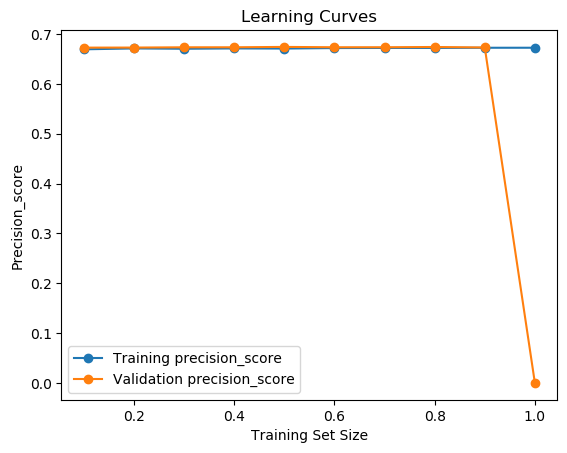

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
from chefboost import Chefboost as chef

# Configure the model parameters
config = {
    'algorithm': 'CHAID',
    'learning_rate': 9.5,
    'enableParallelism': True,
    'max_depth': 7,
    'num_of_weak_classifier': 7,
    'enableRandomForest':True,
    'num_trees':6,
    'epochs':15,
    'enableMultitasking':True
}

# Store the sizes of the training set
train_sizes = np.linspace(0.1, 1.0, 10, endpoint=True)

# Initialize lists to store training and validation F1-scores
train_scores = []
val_scores = []

for train_size in train_sizes:
    # Calculate the number of samples for the current training set size
    num_samples = int(train_size * analysis_data.shape[0])

    # Split the data into training and validation sets
    train_data = analysis_data[:num_samples]
    val_data = analysis_data[num_samples:]

    # Train model
    model = chef.fit(train_data, config=config, target_label='isFraud_cluster')

    # Make predictions on the training set
    train_predictions = []
    for _, row in train_data.iterrows():
        prediction = chef.predict(model, row)
        train_predictions.append(prediction)

    # Make predictions on the validation set
    val_predictions = []
    for _, row in val_data.iterrows():
        prediction = chef.predict(model, row)
        val_predictions.append(prediction)

    # Calculate the F1-scores
    train_f1_score = precision_score(train_data['isFraud_cluster'], train_predictions, pos_label='Fraud', average='binary')
    val_f1_score = precision_score(val_data['isFraud_cluster'], val_predictions, pos_label='Fraud', average='binary')

    # Append the F1-scores to the lists
    train_scores.append(train_f1_score)
    val_scores.append(val_f1_score)

# Plot the learning curves
plt.plot(train_sizes, train_scores, 'o-', label='Training precision_score')
plt.plot(train_sizes, val_scores, 'o-', label='Validation precision_score')
plt.xlabel('Training Set Size')
plt.ylabel('Precision_score')
plt.title('Learning Curves')
plt.legend()
plt.show()

In [56]:
# Predict for all rows in the test data
predictions = []
TP = 0  # True Positives
FP = 0  # False Positives
TN = 0  # True Negatives
FN = 0  # False Negatives

for i in range(len(test_data)):
    test_instance = test_data.iloc[i]
    prediction = chef.predict(model, test_instance)
    predictions.append(prediction)

   # Compare the prediction with the actual target value
    if prediction == "Fraud" and y_test.iloc[i] == "Fraud":
        TP += 1
    elif prediction == "Fraud" and y_test.iloc[i] == "No_Fraud":
        FP += 1
    elif prediction == "No_Fraud" and y_test.iloc[i] == "No_Fraud":
        TN += 1
    elif prediction == "No_Fraud" and y_test.iloc[i] == "Fraud":
        FN += 1

# Print the predictions
print(predictions)

# Print the counts for TP, FP, TN, and FN
print("True Positives (TP):", TP)
print("False Positives (FP):", FP)
print("True Negatives (TN):", TN)
print("False Negatives (FN):", FN)

# Calculate precision
precision = TP / (TP + FP)

# Calculate recall
recall = TP / (TP + FN)

# Calculate F1 score
f1_score = 2 * (precision * recall) / (precision + recall)

# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1_score)

['Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'Fraud', 'No_Fraud', 'Fraud', 'No_Fraud', 'No_Fraud', 'Fraud', 'Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'Fraud', 'Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'Fraud', 'Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'Fraud', 'No_Fraud', 'No_Fraud', 'Fraud', 'Fraud', 'No_Fraud', 'Fraud', 'No_Fraud', 'No_Fraud', 'Fraud', 'No_Fraud', 'No_Fraud', 'Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'Fraud', 'No_Fraud', 'No_Fraud', 'Fraud', 'No_Fraud', 'No_Fraud', 'Fraud', 'No_Fraud', 'No_Fraud', 'Fraud', 'No_Fraud', 'Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'Fraud', 'Fraud', 'No_Fraud', 'Fraud', 'Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'Fraud', 'No_Fraud', 'No_Fraud', 'Fraud', 'Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No_Fraud', 'No